# Logistic Regression, Random Forest and Boosted RF Analysis 

### I. [Setting the stage](#Features)
### II. [Logistic regression model](#Logistic-Regression)
### III. [Random forest model](#Random-Forest)
### IV. [Conclusions and use](#Recommended-use)

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes = True)
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

# Boosting
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier, BaggingClassifier

from sklearn.metrics import confusion_matrix

from sklearn.pipeline import Pipeline

In [2]:
# To display all the rows and columns
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)

### Import Data Files

During the data cleaning phase of this project we divided the training and testing data. This was necessary because the original data file was too large for the github repository and caused glitches when we tried to push the file. As a result, each csv file is one component of the train/test split. 

In [3]:
X_train = pd.read_csv('../datasets/X_train_w_SA_and_words.csv')
X_test = pd.read_csv('../datasets/X_test_w_SA_and_words.csv')
y_train = pd.read_csv('../datasets/y_train.csv')
y_test = pd.read_csv('../datasets/y_test.csv')

In [4]:
# Scaled X
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

### Features

The features include four types of data. 

The first type is targeted stats about the news articles, including but not limited to the following: number of words in the headline and text, number of characters in the headline and text, number of special characters ($, #, ?, !, etc.), and ratios. These features account for 23 columns. 

The second and third types are sentiment analysis and part of speech tagging. These features make up 26 columns.

The fourth type is stemmed words from the text. These features make up 575 columns. 

In [5]:
print('Total number of features: ', X_train.shape[1])

Total number of features:  626


### Baseline Model

The baseline model is the percentage of the majority class. In this case, Real News in the majority class at 53.2%. I checked that the train and test sets had equal baseline scores. 

In [6]:
# baseline accuracy - the percentage of the majority class
y_train['is_true'].value_counts(normalize=True)

1    0.532165
0    0.467835
Name: is_true, dtype: float64

In [7]:
# baseline accuracy - the percentage of the majority class
y_test['is_true'].value_counts(normalize=True)

1    0.532163
0    0.467837
Name: is_true, dtype: float64

## Logistic Regression

### Summary

The main challenge with Logistic Regression Classification is a high variance and thus overfit models. The table below shows the training and testing accuracy and cross val scores for each model. The first two model scores are essentially perfect at 99%+. The confusion matrix for each model showed an immaterial amount of false positives and negatives, less than 1%. I decided to use regularization to address the overfit models. 

Regularization does not improve the performance on the data set that the model used to learn the model parameters. However, it can improve the generalization performance, i.e., the performance on new, unseen data, which is exactly what we want.

In intuitive terms, we can think of regularization as a penalty against complexity. Increasing the regularization strength penalizes "large" weight coefficients. Our goal is to prevent that our model picks up "peculiarities," "noise," or "imagines a pattern where there is none." We don't want the model to memorize the training dataset, we want a model that generalizes well to new, unseen data.

Regularizing the logistic regression model adds bias but not too much bias. The testing cross val score of 86% is significantly better than the baseline score of 53%. While I would like the training and testing cross val score to be closer than the current 7 point spread it is the lesser of two evil when compared to the other overfit models. Additionally, the regularized model has a high testing accuracy score of 94%.

source: https://www.kdnuggets.com/2016/06/regularization-logistic-regression.html

| Model                                        | Accuracy Score - Train | Accuracy Score - Test | CrossValScore - Train | CrossValScore - Test |
|----------------------------------------------|------------------------|-----------------------|-----------------------|----------------------|
| Logistic Regression - Not Scaled             | 0.991                  | 0.992                 | 0.989                 | 0.991                |
| Logistic Regression - Scaled                 | 0.999                  | 0.995                 | 0.995                 | 0.992                |
| Logistic Regression - Scaled and Regularized | 0.937                    | 0.944                 | 0.929                 | 0.859                |

### No Standard Scaler

In [8]:
# instantiate the model
logr = LogisticRegression()

# fit the model
model = logr.fit(X_train, y_train.values.ravel())

# Accuracy Scores
score = model.score(X_train, y_train)
print(f'Training Accuracy of Model is: {score}')

score = model.score(X_test, y_test)
print(f'Testing Accuracy of Model is: {score}')

# Cross Val Scores
print()
print('Training Cross Val Score: ', cross_val_score(logr, X_train, y_train, cv = 5, n_jobs = -1).mean())
print('Testing Cross Val Score: ', cross_val_score(logr, X_test, y_test, cv = 5, n_jobs = -1).mean())

# https://stackoverflow.com/questions/34165731/a-column-vector-y-was-passed-when-a-1d-array-was-expected

/Users/elliotrichardson/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Accuracy of Model is: 0.9888602682902352
Testing Accuracy of Model is: 0.989764174611139

Training Cross Val Score:  0.99080047703485
Testing Cross Val Score:  0.9910687405920722


### Confusion Matrix - No Standard Scaler

In [9]:
# Confusion Matrix
# Compute confusion matrix
y_predicted_labels = model.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_predicted_labels)
np.set_printoptions(precision=2)
cnf_matrix

array([[4615,   47],
       [  55, 5248]])

In [10]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# code --> https://www.kaggle.com/paragap/fake-news-prediction-algorithm

Confusion matrix, without normalization
[[4615   47]
 [  55 5248]]
Normalized confusion matrix
[[0.99 0.01]
 [0.01 0.99]]


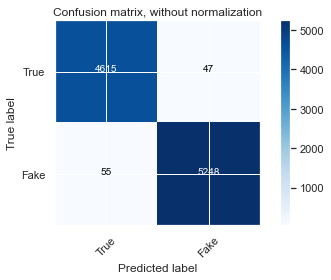

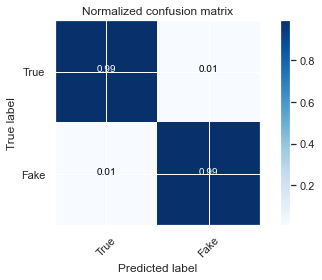

In [11]:
#Without Normalization
plt.figure()
plot_confusion_matrix(cnf_matrix, classes= ['True', 'Fake'],
                      title='Confusion matrix, without normalization')
# With normalization
plt.figure()
plot_confusion_matrix(cnf_matrix, classes= ['True', 'Fake'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

The confusion matrix shows a near perfect model. Less than 1% of data fall into the false positive and false negative categories. 

### Standard Scaler

In [12]:
# instantiate the model
logr = LogisticRegression()

# fit the model
model = logr.fit(X_train_sc, y_train.values.ravel())

# Accuracy Scores
score = model.score(X_train_sc, y_train)
print(f'Training Accuracy of Model is: {score}')

score = model.score(X_test_sc, y_test)
print(f'Testing Accuracy of Model is: {score}')

# Cross Val Scores
print()
print('Training Cross Val Score: ', cross_val_score(logr, X_train_sc, y_train, cv = 5, n_jobs = -1).mean())
print('Testing Cross Val Score: ', cross_val_score(logr, X_test_sc, y_test, cv = 5, n_jobs = -1).mean())

/Users/elliotrichardson/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Accuracy of Model is: 0.9998996420566688
Testing Accuracy of Model is: 0.9954841946813848

Training Cross Val Score:  0.9946475707241431
Testing Cross Val Score:  0.9923733065730055


### Confusion Matrix - Scaled

In [13]:
#Confusion Matrix
# Compute confusion matrix
y_predicted_labels = model.predict(X_test_sc)
cnf_matrix = confusion_matrix(y_test, y_predicted_labels)
np.set_printoptions(precision=2)
cnf_matrix

array([[4633,   29],
       [  16, 5287]])

Confusion matrix, without normalization
[[4633   29]
 [  16 5287]]
Normalized confusion matrix
[[0.99 0.01]
 [0.   1.  ]]


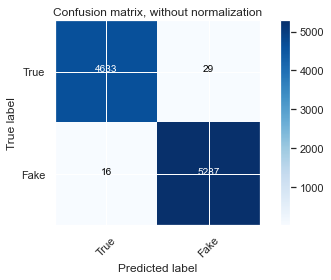

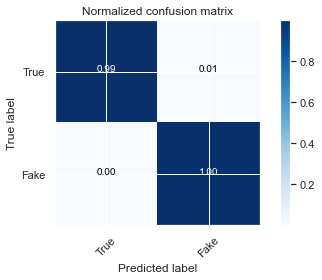

In [14]:
#Without Normalization
plt.figure()
plot_confusion_matrix(cnf_matrix, classes= ['True', 'Fake'],
                      title='Confusion matrix, without normalization')
# With normalization
plt.figure()
plot_confusion_matrix(cnf_matrix, classes= ['True', 'Fake'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Again, the confusion matrix shows a near perfect model. Less than 1% of data fall into the false positive and false negative categories.

### Regularizing Logistic Regression

I included to methods to see if LogisticRegression and LogisticRegressionCV produced the same results, which they did. The model uses an alpha value of 0.00001 and solver lbfgs, which is good for larger datasets. 

#### Method 1: LogisticRegression

In [15]:
logreg = LogisticRegression(C=0.00001, solver='lbfgs')
logreg.fit(X_train_sc, y_train.values.ravel())

LogisticRegression(C=1e-05)

In [16]:
# Accuracy Scores
score = logreg.score(X_train_sc, y_train)
print(f'Training Accuracy of Model is: {score}')

score = logreg.score(X_test_sc, y_test)
print(f'Testing Accuracy of Model is: {score}')

# Cross Val Scores
print()
print('Training Cross Val Score: ', cross_val_score(logreg, X_train_sc, y_train, cv = 5, n_jobs = -1).mean())
print('Testing Cross Val Score: ', cross_val_score(logreg, X_test_sc, y_test, cv = 5, n_jobs = -1).mean())

Training Accuracy of Model is: 0.9366741377580036
Testing Accuracy of Model is: 0.943803311590567

Training Cross Val Score:  0.9293146566120711
Testing Cross Val Score:  0.8589061716006021


#### Method 2: LogisticRegressionCV

In [17]:
logregcv = LogisticRegressionCV(Cs=np.array([0.00001]), penalty='l2', solver='lbfgs')
logregcv.fit(X_train_sc, y_train.values.ravel())

LogisticRegressionCV(Cs=array([1.e-05]))

In [18]:
Cs=[1.5, 2, 3, 4, 5]
Cs=np.array([0.1, 1])
penalty='l2'

np.array([0.000001, 0.0000001,  0.00000001])

np.logspace(-4, 4, 20)

array([1.00e-04, 2.64e-04, 6.95e-04, 1.83e-03, 4.83e-03, 1.27e-02,
       3.36e-02, 8.86e-02, 2.34e-01, 6.16e-01, 1.62e+00, 4.28e+00,
       1.13e+01, 2.98e+01, 7.85e+01, 2.07e+02, 5.46e+02, 1.44e+03,
       3.79e+03, 1.00e+04])

In [19]:
import time
start_time = time.time()

# Accuracy Scores
score = logregcv.score(X_train_sc, y_train)
print(f'Training Accuracy of Model is: {score}')

score = logregcv.score(X_test_sc, y_test)
print(f'Testing Accuracy of Model is: {score}')

# Cross Val Scores
print()
print('Training Cross Val Score: ', cross_val_score(logregcv, X_train_sc, y_train, cv = 5, n_jobs = -1).mean())
print('Testing Cross Val Score: ', cross_val_score(logregcv, X_test_sc, y_test, cv = 5, n_jobs = -1).mean())

end_time = time.time()
print()
print('Took %s seconds to calculate.' % (end_time - start_time))

Training Accuracy of Model is: 0.9366741377580036
Testing Accuracy of Model is: 0.943803311590567

Training Cross Val Score:  0.9293146566120711
Testing Cross Val Score:  0.8589061716006021

Took 36.51624584197998 seconds to calculate.


### Confusion Matrix - Scaled and Regularized

In [20]:
#Confusion Matrix
# Compute confusion matrix
y_predicted_labels = logregcv.predict(X_test_sc)
cnf_matrix = confusion_matrix(y_test, y_predicted_labels)
np.set_printoptions(precision=2)
cnf_matrix

array([[4139,  523],
       [  37, 5266]])

Confusion matrix, without normalization
[[4139  523]
 [  37 5266]]
Normalized confusion matrix
[[0.89 0.11]
 [0.01 0.99]]


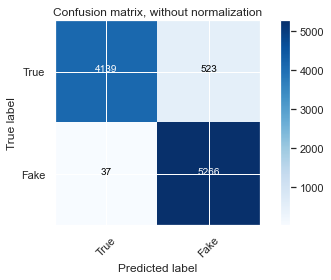

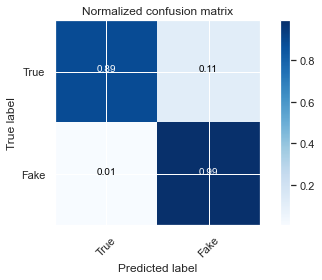

In [21]:
#Without Normalization
plt.figure()
plot_confusion_matrix(cnf_matrix, classes= ['True', 'Fake'],
                      title='Confusion matrix, without normalization')
# With normalization
plt.figure()
plot_confusion_matrix(cnf_matrix, classes= ['True', 'Fake'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

11% of the data is classified as False negative (predicted fake news but it was real). It's hard to determine which error is worse. Is it better to be more skeptical and to categorize real news as fake or be more open to information and categorize more fake news as real. The preference would depend on the reader and the circumstances of the information. This model can be viewed as being more skeptical with a strong fake news filter.

## Random Forest

### Summary

The Random Forest and Boosted Random Forest also suffered from high variance. 

In [22]:
rf = RandomForestClassifier(n_estimators=150, max_depth=None, n_jobs=-1)

rf_model = rf.fit(X_train, y_train)

# Confusion Matrix
# Compute confusion matrix
y_predicted_labels = rf_model.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_predicted_labels)
np.set_printoptions(precision=2)
cnf_matrix

# code --> https://www.kaggle.com/sauravmaheshkar/fake-news-classification-using-random-forest

<ipython-input-22-3271f895bba4>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model = rf.fit(X_train, y_train)


array([[4659,    3],
       [  11, 5292]])

Confusion matrix, without normalization
[[4659    3]
 [  11 5292]]
Normalized confusion matrix
[[9.99e-01 6.44e-04]
 [2.07e-03 9.98e-01]]


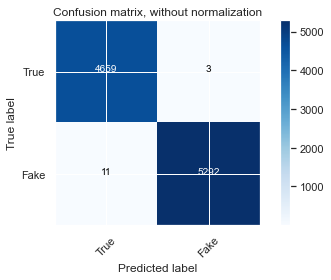

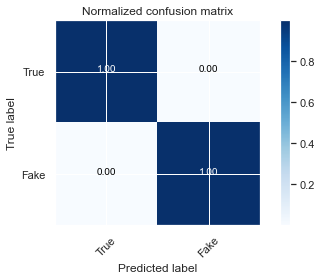

In [23]:
#Without Normalization
plt.figure()
plot_confusion_matrix(cnf_matrix, classes= ['True', 'Fake'],
                      title='Confusion matrix, without normalization')
# With normalization
plt.figure()
plot_confusion_matrix(cnf_matrix, classes= ['True', 'Fake'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Another perfect model indicating that it's overfit.

### Boosted Random Forest

GridSearch is commented out for efficiency but the best parameters are used in a model below.

In [24]:
# # code --> by Riley Dallas from Austin

# start_time = time.time()

# ada = AdaBoostClassifier(base_estimator=RandomForestClassifier())
# ada_params = {
#     'n_estimators': [50,100],
#     'base_estimator__max_depth': [1,2],
#     'learning_rate': [.9, 1.]
# }
# gs = GridSearchCV(ada, param_grid=ada_params, cv=3)
# gs.fit(X_train,y_train.values.ravel())
# print('Best score:', gs.best_score_, '\nBest params:',gs.best_params_)

# end_time = time.time()
# print()
# print('Took %s seconds to calculate.' % (end_time - start_time))

# print('Training set score:',gs.score(X_train, y_train), '\nTesting set score:',gs.score(X_test, y_test))


In [26]:
ada = AdaBoostClassifier(base_estimator=RandomForestClassifier(max_depth = 2),
                         learning_rate = 1.0, n_estimators = 100)
ada.fit(X_train,y_train.values.ravel())

AdaBoostClassifier(base_estimator=RandomForestClassifier(max_depth=2),
                   n_estimators=100)

In [27]:
ada.score(X_train,y_train),ada.score(X_test,y_test)

(1.0, 0.9997992975413948)

The Boosted Random Forest is another overfit model with high variance, due to a perfect training score and a near perfect testing score. 

## Recommended use

Though our Boosted Random Forest model was the most accurate, we were skeptical that it would perform as well on data outside of this Kaggle set. Thus in order to demonstrate our recommended use for such a model, we utilized our logistic regression model to simulate what we think are more realistic results. 

Below, we created a function that would take two thresholds to create a third classification: "Unsure". This is so any manual fact-checking that needs to be done can be applied only to the articles that might actually be true. Articles with very high likelihoods of falsity will be classified as such so that fact-checkers can focus their efforts on articles that are harder to classify confidently. Our recommendation is that platforms determine their thresholds based on whether they are trying to optimize for overall accuracy, sensitivity, specificity, or the least possible manual fact-checking. See our experiments below to get a sense of how this could work.

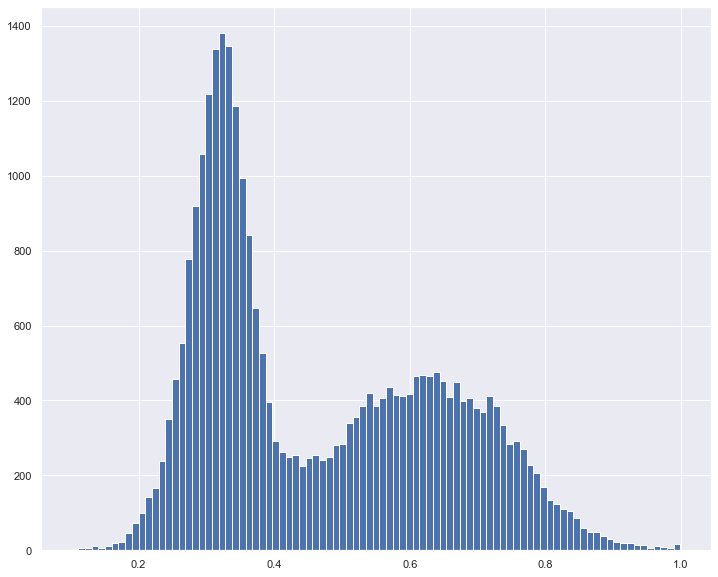

In [28]:
preds = pd.DataFrame(logregcv.predict_proba(X_train_sc))
preds.columns = ['fake_prob', 'true_prob']

plt.figure(figsize=(12,10))
plt.hist(preds['fake_prob'],bins = 91);

In [29]:
def try_probs(upper,lower):
    preds = pd.DataFrame(logregcv.predict_proba(X_test_sc))
    preds.columns = ['fake_prob', 'true_prob']
    preds['true'] = y_test
    preds['pred_fake'] = 0
    preds['pred_real'] = 0
    preds['pred_unsure'] = 0
    
    for i, prob in enumerate(preds['fake_prob']):
        if prob >  upper:
            preds.loc[i, 'pred_fake'] = 1
        elif prob < lower:
            preds.loc[i, 'pred_real'] = 1
        else:
            preds.loc[i, 'pred_unsure'] = 1
    
    is_true = preds['true'] == 1
    pred_real = preds['pred_real'] == 1
    pred_fake = preds['pred_fake'] == 1
    pred_unsure = preds['pred_unsure'] == 1
    
    rows = preds.shape[0]
    fp = preds[pred_real & ~is_true].shape[0]
    tp = preds[pred_real & is_true].shape[0] 
    fn = preds[pred_fake & is_true].shape[0] 
    tn = preds[pred_fake & ~is_true].shape[0] 
    misclass = fp+fn
    unsure = preds['pred_unsure'].sum()
    unsure_fake = preds[pred_unsure & ~is_true].shape[0]
    unsure_real = preds[pred_unsure & is_true].shape[0]
    correct = rows - misclass - unsure
    
    plt.figure(figsize=(16,8))
    plt.hist(preds['fake_prob'],bins = 91, histtype = 'step')
    plt.axvspan(0, lower, alpha=0.2, color='green', label = 'Classified "Real"')
    plt.axvspan(lower, upper, alpha=0.15, color='orange', label = 'Classified "Unsure"')
    plt.axvspan(upper, 1, alpha=0.2, color='red', label = 'Classified "Fake"')
    
    plt.title(chart_title+' -- Correctly Classified: '+str(round((correct/rows) * 100,2))+'%',
             fontsize = 20, pad = 10)
    plt.ylabel('Count', fontsize = 16, labelpad = 10)
    plt.xlabel('Probability of Falseness (as predicted by our model)', fontsize = 16, labelpad = 10)
    plt.xticks(np.arange(0,1.01,.1),
               labels = ['0%', '10%', '20%', '30%','40%','50%','60%','70%','80%','90%','100%'])
    
    # tp
    plt.text(0.02,425,'True Positives: {}%'.format(round((tp/rows)*100,2)),
             fontdict = {'color': 'green', 'fontsize': 20})
    # fp
    plt.text(0.02,325,'False Positives: {}%'.format(round((fp/rows)*100,2)),
             fontdict = {'color': 'red', 'fontsize': 20})
    # tn
    plt.text(0.55,425,'True Negatives: {}%'.format(round((tn/rows)*100,2)),
             fontdict = {'color': 'red', 'fontsize': 20})
    #fn
    plt.text(0.55,325,'False Negatives: {}%'.format(round((fn/rows)*100,2)),
             fontdict = {'color': 'green', 'fontsize': 20})
    
    # total unsure
    plt.text(lower+0.005,225,'{}%'.format(round((unsure/rows)*100,2)),
             fontdict = {'color': 'orange', 'fontsize': 20})
    plt.text(lower+0.005,190,'total',
             fontdict = {'color': 'orange', 'fontsize': 16})
    # unsure fake
    plt.text(lower+0.005,425,'{}%'.format(round((unsure_fake/rows)*100,2)),
             fontdict = {'color': 'red', 'fontsize': 20})
    # unsure real
    plt.text(lower+0.005,325,'{}%'.format(round((unsure_real/rows)*100,2)),
             fontdict = {'color': 'green', 'fontsize': 20})
    plt.legend(fontsize = 12);
                                                                                        
    return plt.show()
    

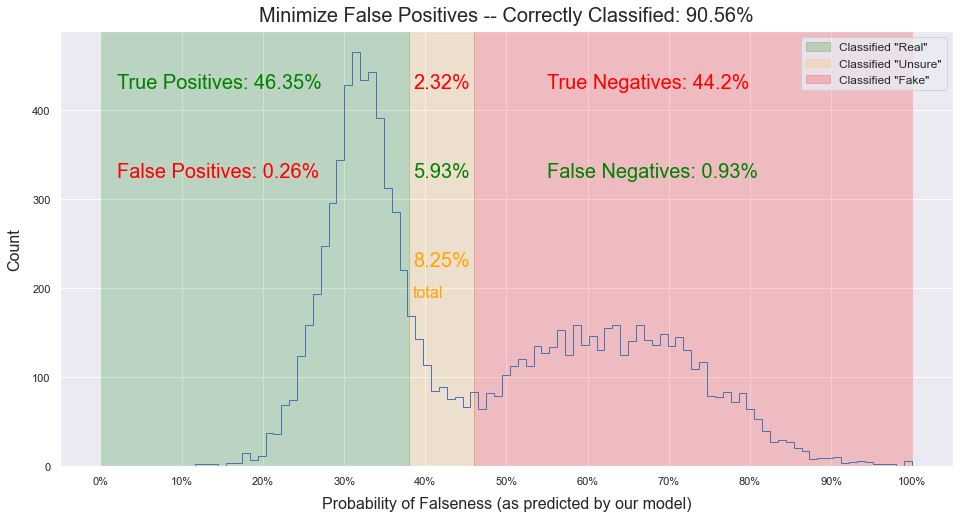

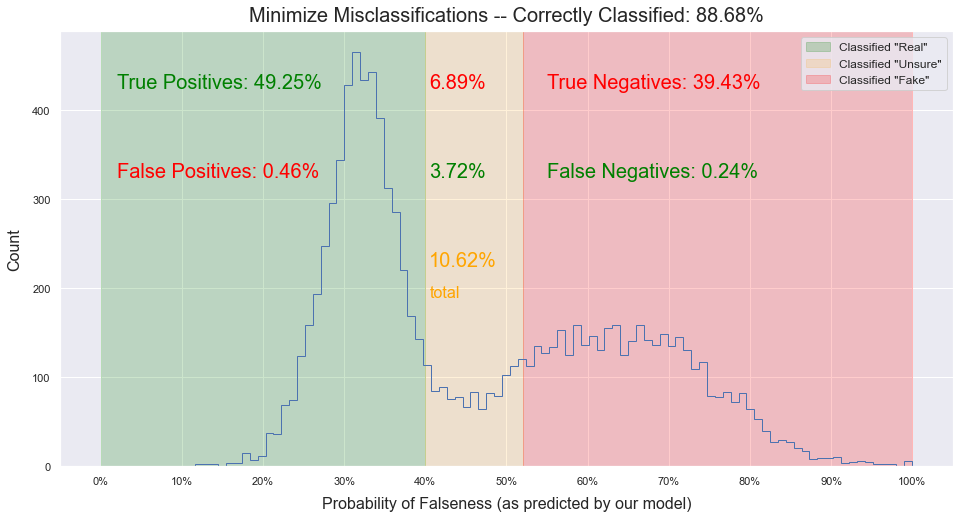

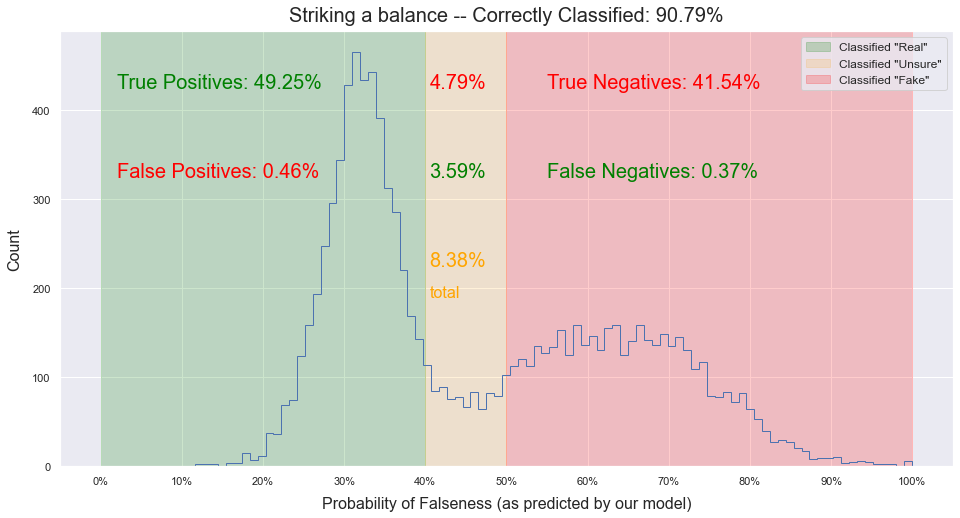

In [31]:
# least false positives, medium manual work
try_probs(0.46,0.38, chart_title = 'Minimize False Positives') 

# least misclassified, most manual work
try_probs(0.52,0.4, chart_title = 'Minimize Misclassifications')

# balanced
try_probs(0.5,0.4, chart_title = 'Striking a balance')